In [ ]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [ ]:
ti = 0.07
tf = 3
from LensCalcPy.parameters import *

In [ ]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

In [ ]:
t_es = np.logspace(-2, 1, 20) #hours

In [82]:
# alpha = 2
p = 1

s.add_ffp(p)
diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=False)

In [83]:
diff_rates_finite = s.get_crossing_times_rates_ffp(t_es, finite=True)

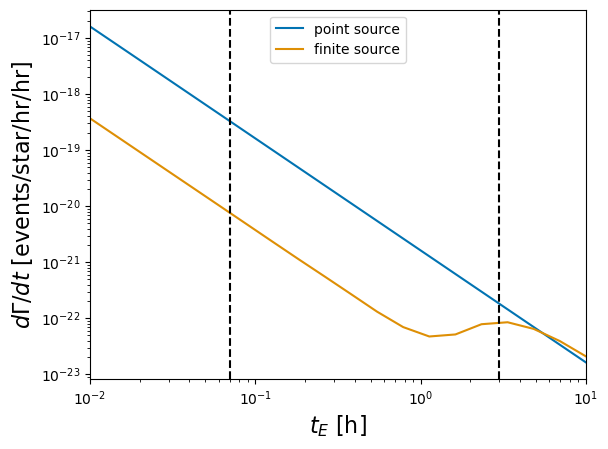

In [84]:
plt.loglog(t_es, diff_rates, label='point source')
plt.loglog(t_es, diff_rates_finite, label='finite source')

# Add lines for HSC sensitivity window
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
# plt.ylim(1e-16,1e-7)
plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.legend()
plt.show()

In [ ]:
def get_n_events(A, p=1, finite=False):
    #Now A is number of FFPs per star
    s.add_ffp(p)
    diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime*A

def get_n_events_parallel(As, p=1, finite=False):
    with Pool() as p:
        f = functools.partial(get_n_events, p=p, finite=finite)
        results = list(p.imap(f, As))
    return results

In [ ]:
n_events = get_n_events(1, p=p, finite=False)

In [ ]:
n_events_finite = get_n_events(1, p=p, finite=True)

In [ ]:
print(n_events)
print(n_events_finite)

## 2D exclusion plots

In [ ]:
A_min = 1
A_max = 1e8
alpha_min = 1.1
alpha_max = 2.5
num_points = 20
A_values = np.logspace(np.log10(A_min), np.log10(A_max), num_points)
alpha_values = np.linspace(alpha_min, alpha_max, num_points) 
A_grid, alpha_grid = np.meshgrid(A_values, alpha_values)

p_min = 0.5
p_max = 1.5
p_values = np.linspace(p_min, p_max, num_points) 

In [ ]:
# get_n_events_values = np.empty_like(A_grid)

# for i in tqdm(range(len(alpha_values))):
#     get_n_events_values[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=False)

In [ ]:
# get_n_events_values_finite = np.empty_like(A_grid)

# for i in tqdm(range(len(alpha_values))):
#     get_n_events_values_finite[i] = get_n_events_parallel(A_values, alpha=alpha_values[i], finite=True)

In [ ]:
# plt.figure()
# contour = plt.contourf(A_grid, alpha_grid, get_n_events_values, levels=[4.74, 1e10])
# plt.contourf(A_grid, alpha_grid, get_n_events_values_finite, levels=[4.74, 1e10], colors="red", alpha=0.5)
# plt.xscale('log')
# plt.title('Excluded Region for 1 Observation')
# plt.xlabel('N')
# plt.ylabel('p')
# plt.show()

In [130]:
M_sun = 1.99e30
M_earth = 5.97e24

def get_constraint_iso(m_iso, p=1, finite=False):
    if m_iso < 1e-15:
        raise ValueError('Mass must be greater than 1e-15')
    
    #Number of total events assuming 1 total per star
    #Note Z doesn't matter for this part of the calculation
    n_events = get_n_events(1, p=p, finite=finite)
    s.add_ffp(p)

    # Normalization check
    if abs(1 - nquad(s.ffp.mass_func,[[np.log10(s.ffp.m_min), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]) > 1e-2:
        raise ValueError('Normalization of mass function is off by more than 1e-2')

    #Porportion of ISOs above threshold
    proportion_above_threshold = nquad(s.ffp.mass_func,[[np.log10(m_iso), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

    #New normalization for Z such that \Gamma *t_obs = 4.74
    N_thresh = 4.74/n_events

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_thresh * proportion_above_threshold    

def get_constraint_dex(m_iso, p=1, finite=False):
    if m_iso < 10**(-14.5):
        raise ValueError('Mass must be greater than 10**(-14.5)')
    
    #Number of total events assuming 1 total per star
    #Note Z doesn't matter for this part of the calculation
    n_events = get_n_events(1, p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events

    # Normalization check
    if abs(1 - nquad(s.ffp.mass_func,[[np.log10(s.ffp.m_min), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]) > 1e-2:
        raise ValueError('Normalization of mass function is off by more than 1e-2')

    #Porportion of ISOs within threshold
    N_ffp_dex = Z * nquad(s.ffp.mass_func,[[np.log10(m_iso)-0.5,np.log10(m_iso)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_ffp_dex

In [131]:
get_constraint_dex(3e-6, p=0.9, finite=True)

38256.3487561648

In [ ]:
get_constraint_iso(1, p=0.9, finite=True)

In [ ]:
n_events = get_n_events(1, p=0.9, finite=True)

In [128]:
print(n_events)

9.020498125589216e-13


In [92]:
N_thresh = 4.74/n_events
print(N_thresh)

5254698725066.677


In [129]:
s.add_ffp(0.9)

print(N_thresh*nquad(s.ffp.mass_func,[[np.log10(M_earth/M_sun*0.33), np.log10(M_earth/M_sun* 6660)]], opts={'points': [s.ffp.m_min, s.ffp.m_min*1e3, s.ffp.m_max*1e-6, s.ffp.m_max*1e-3]})[0])


42113.19162645256


In [99]:
N_thresh*(1/3e-6)**(-0.9)

56228558.555594064

In [71]:
42113 * local_stellar_density * kpc2au ** (-3) 

1.7818638044538323e-13

In [ ]:
confidence_level_threshold = 0.05

Nexp = 1

# Calculate the cumulative probability until it exceeds the threshold
while True:
    # cumulative_prob = poisson.pmf(0, Nexp) + poisson.pmf(1, Nexp) 
    cumulative_prob = poisson.pmf(1, Nexp) 
    if cumulative_prob <= confidence_level_threshold:
        break
    Nexp += 0.01 

print(f"The 95% C.L. is reached when Nexp <= {Nexp}")

### Constraints on local ISO Density

In [ ]:
def get_n_events_pbh(m, finite=False):
    s.add_pbh(m)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

def get_constraint_fdm(m, finite=False):
    n_events = get_n_events_pbh(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1

In [ ]:
#https://arxiv.org/pdf/1910.08608.pdf handwavy constraint in au^-3

local_dm_density = density_mw(dist_mw(0))
m_pbh = 1e-10
fpbh = get_constraint_fdm(m_pbh, finite=True)
kpc2au = 2.06e8

print("upper limit on number density of ISOs in au^-3 from HSC PBH constrint")
print(local_dm_density*kpc2au**(-3)*fpbh/m_pbh)

In [ ]:
#Comparison with FFP distribution (new velocity dispersion)
local_stellar_density = rho_FFPs_mw(0)
m_iso = 1e-10
alpha = 1.83

#number of ISOs per star with mass greater than m_iso
n_objects = get_constraint_iso(m_iso, alpha=alpha, finite=True)

print("upper limit on number density of ISOs in au^-3 with mass greater than {} for alpha = {}".format(m_iso, alpha))
print(local_stellar_density*kpc2au**(-3)*n_objects)

In [ ]:
with Pool() as p:
    f = functools.partial(get_constraint_iso, m_iso, finite=True)
    n_objects_arr = list(tqdm(p.imap(f, alpha_values), total=len(alpha_values)))

In [ ]:
loeb_alpha = 3.41
loeb_err = 0.17
loeb_p = loeb_alpha/3 + 1
loeb_p_err = loeb_err/3
loeb_n = 2.6e-14

dohanyi_alpha = 2.5
dohanyi_p = dohanyi_alpha/3 + 1
dohanyi_n = 7.2e-11

In [ ]:
#new
au3_to_pc3 = (4.85e-6)**3
num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

plt.figure()

plt.plot(alpha_values, num_densities, label='This Work')
plt.fill_between(alpha_values, num_densities, 1, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs with $M > 10^{-10}$ M$_\odot$')

plt.xlim([1.1, 2.5])
plt.ylim([1e-14, 1e-5])

plt.plot(dohanyi_p, dohanyi_n, 'o', label='Dohanyi 600km')
plt.errorbar(loeb_p, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.legend()

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-14/au3_to_pc3, 1e-9/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


Now do for different ISO masses

In [ ]:
m_arr = np.logspace(-10, -6, 3)
m_arr 

In [ ]:
n_objects_dict = {}

In [ ]:
for m in m_arr:
    with Pool() as p:
        f = functools.partial(get_constraint_iso, m, finite=True)
        n_objects_dict[m] = list(tqdm(p.imap(f, p_values), total=len(p_values)))

In [132]:
n_objects_dex_dict = {}

for m in m_arr:
    with Pool() as p:
        f = functools.partial(get_constraint_dex, m, finite=True)
        n_objects_dex_dict[m] = list(tqdm(p.imap(f, p_values), total=len(p_values)))

100%|██████████| 20/20 [04:27<00:00, 13.39s/it]


In [133]:
density = 2  # g/cm^3
msol_to_g = 1.99e33
diameters = {}

for m in m_arr:
    diameters[m] = (6*m*msol_to_g/(np.pi*density))**(1/3) * 1e-5 # diameter in km
diameters

{1e-10: 574.9209741947893,
 1e-08: 2668.5467740323147,
 1e-06: 12386.296908321794}

In [134]:
MOA_N = 2.18
MOA_p = 0.96
KMT_N = 0.4
KMT_p = 0.92

N_MOA = quad(lambda x: MOA_N*(10**x/8)**(-MOA_p), np.log10(0.33), np.log10(6660))[0]
N_KMT = quad(lambda x: KMT_N*(10**x/38)**(-KMT_p), np.log10(0.33), np.log10(6660))[0]

print(N_MOA)
print(N_KMT)

MOA_n = N_MOA * local_stellar_density * kpc2au ** (-3) 
KMT_n = N_KMT * local_stellar_density * kpc2au ** (-3) 

print("MOA number density: {}".format(MOA_n))
print("KMT number density: {}".format(KMT_n))

21.04411106964539
14.872261024601801
MOA number density: 8.904077081164329e-17
KMT number density: 6.292675328313683e-17


In [73]:
quad(lambda x: MOA_N*(10**x/8)**(-MOA_p), np.log10(0.33), np.log10(6660))

(21.04411106964539, 2.336365664228944e-13)

In [106]:
np.array(n_objects_arr) * kpc2au ** (-3)


array([5.90382149e-20, 4.39503446e-20, 3.24700424e-20, 2.37726132e-20,
       1.72077100e-20, 1.22914347e-20, 8.64984704e-21, 5.98945267e-21,
       4.07724743e-21, 2.72751208e-21, 1.79299966e-21, 1.15862595e-21,
       7.36351147e-22, 4.60548182e-22, 2.83643554e-22, 1.72100973e-22,
       1.02901283e-22, 6.06291297e-23, 3.51900680e-23, 2.01063309e-23])

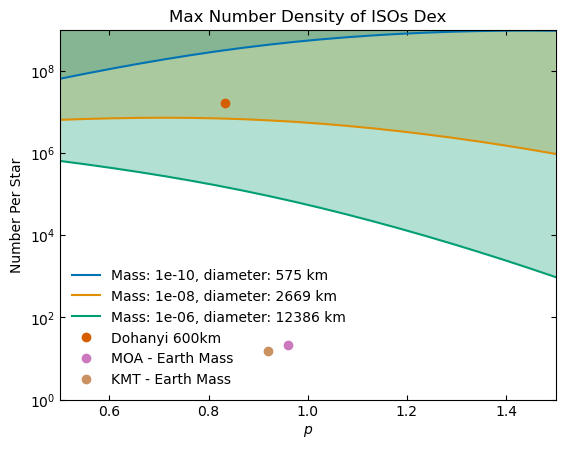

In [140]:
#new
plt.figure()

# Loop over the dictionary items
for mass, n_objects_arr in n_objects_dex_dict.items():
    # plt.plot(alpha_values, num_densities, label=f'Mass: {mass} M$_\odot$, diameter: {diameters[mass]:.0f} km')
    plt.plot(p_values, n_objects_arr, label=f'Mass: {mass}, diameter: {diameters[mass]:.0f} km')

    plt.fill_between(p_values, n_objects_arr, 1e10, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Per Star')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs Dex')

plt.xlim([min(p_values), max(p_values)])
plt.ylim([1e0, 1e9])

plt.plot(dohanyi_p-1, dohanyi_n/local_stellar_density*(kpc2au)**3, 'o', label='Dohanyi 600km')
# plt.errorbar(loeb_p-1, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.plot(MOA_p, N_MOA, 'o', label='MOA - Earth Mass')
plt.plot(KMT_p, N_KMT, 'o', label='KMT - Earth Mass')

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

plt.show()


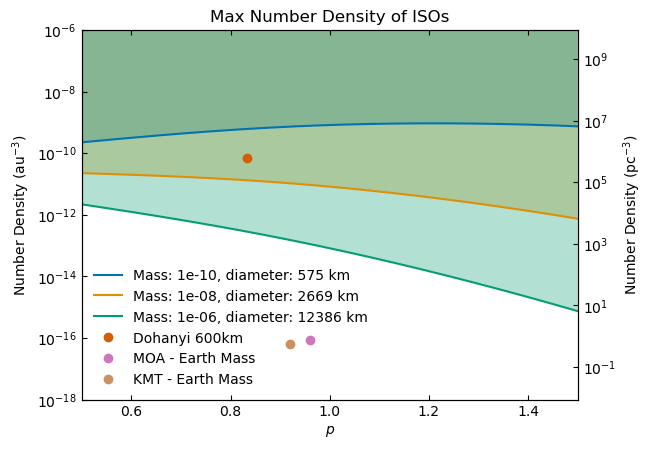

In [102]:
#new
plt.figure()

# Loop over the dictionary items
for mass, n_objects_arr in n_objects_dict.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    # plt.plot(alpha_values, num_densities, label=f'Mass: {mass} M$_\odot$, diameter: {diameters[mass]:.0f} km')
    plt.plot(p_values, num_densities, label=f'Mass: {mass}, diameter: {diameters[mass]:.0f} km')

    plt.fill_between(p_values, num_densities, 1, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs')

plt.xlim([min(p_values), max(p_values)])
plt.ylim([1e-18, 1e-6])

plt.plot(dohanyi_p-1, dohanyi_n, 'o', label='Dohanyi 600km')
# plt.errorbar(loeb_p-1, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.plot(MOA_p, MOA_n, 'o', label='MOA - Earth Mass')
plt.plot(KMT_p, KMT_n, 'o', label='KMT - Earth Mass')

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-18/au3_to_pc3, 1e-6/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


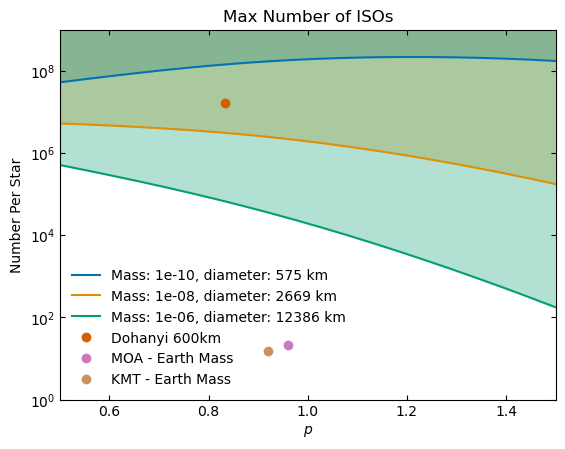

In [118]:
#new
plt.figure()

# Loop over the dictionary items
for mass, n_objects_arr in n_objects_dict.items():
    # plt.plot(alpha_values, num_densities, label=f'Mass: {mass} M$_\odot$, diameter: {diameters[mass]:.0f} km')
    plt.plot(p_values, n_objects_arr, label=f'Mass: {mass}, diameter: {diameters[mass]:.0f} km')

    plt.fill_between(p_values, n_objects_arr, 1e10, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Per Star')
plt.xlabel(r'$p$')
plt.title(r'Max Number of ISOs')

plt.xlim([min(p_values), max(p_values)])
plt.ylim([1e0, 1e9])

plt.plot(dohanyi_p-1, dohanyi_n/local_stellar_density*(kpc2au)**3, 'o', label='Dohanyi 600km')
# plt.errorbar(loeb_p-1, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.plot(MOA_p, N_MOA, 'o', label='MOA - Earth Mass')
plt.plot(KMT_p, N_KMT, 'o', label='KMT - Earth Mass')

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

plt.show()


In [155]:
p_values[19]

1.5

In [157]:
n_objects_dict[1e-6][19]

175.76584515396766

In [ ]:
#new
plt.figure()

# Loop over the dictionary items
for mass, n_objects_arr in n_objects_dict.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    # plt.plot(alpha_values, num_densities, label=f'Mass: {mass} M$_\odot$, diameter: {diameters[mass]:.0f} km')
    plt.plot(p_values, num_densities, label=f'Mass: {mass}')

    plt.fill_between(p_values, num_densities, 1, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs')

plt.xlim([min(p_values), max(p_values)])
plt.ylim([1e-18, 1e-3])

plt.plot(dohanyi_p-1, dohanyi_n, 'o', label='Dohanyi 600km')
plt.errorbar(loeb_p-1, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.plot(MOA_p, MOA_n, 'o', label='MOA')
plt.plot(KMT_p, KMT_n, 'o', label='KMT')

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-15/au3_to_pc3, 1e-9/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


In [ ]:
#old
plt.figure()

# Loop over the dictionary items
for mass, n_objects_arr in n_objects_dict.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    plt.plot(alpha_values, num_densities, label=f'Mass: {mass} M$_\odot$, diameter: {diameters[mass]:.0f} km')
    plt.fill_between(alpha_values, num_densities, 1e-5, alpha=0.3)

plt.yscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$p$')
plt.title(r'Max Number Density of ISOs')

plt.xlim([1.2, 2.3])
plt.ylim([1e-15, 1e-7])

plt.plot(dohanyi_p, dohanyi_n, 'o', label='Dohanyi 600km')
plt.errorbar(loeb_p, loeb_n, xerr=[loeb_p_err], fmt='o', label='Loeb 600km')

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-15/au3_to_pc3, 1e-9/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


### Now as a function of mass instead of alpha

In [ ]:
m_values = np.logspace(-12, -8, 16)
alpha_values_mass = np.linspace(1.6, 2.4, 3)

In [ ]:
n_objects_dict_mass = {}
for alpha in alpha_values_mass:
    with Pool() as p:
        f = functools.partial(get_constraint_iso, alpha=alpha, finite=True)
        n_objects_dict_mass[alpha] = list(tqdm(p.imap(f, m_values), total=len(m_values)))

In [ ]:
plt.figure()

# Loop over the dictionary items
for alpha, n_objects_arr in n_objects_dict_mass.items():
    num_densities = np.array(n_objects_arr) * local_stellar_density * kpc2au ** (-3)

    plt.plot(m_values, num_densities, label=f'$p$: {alpha:.2f}')
    plt.fill_between(m_values, num_densities, 1e-5, alpha=0.3)

plt.yscale('log')
plt.xscale('log')

plt.ylabel(r'Number Density (au$^{-3}$)')
plt.xlabel(r'$\rm{Mass_{min}} [ M_\odot ]$')
plt.title(r'Max Number Density of ISOs')

plt.xlim([1e-12, 1e-8])
plt.ylim([1e-14, 1e-6])

plt.legend(loc='lower left', frameon=False)

plt.tick_params(axis='both', direction='in', which='both', bottom=True, top=True, left=True, right=True)

# creating a twin axis
ax2 = plt.twinx()
ax2.set_ylabel(r'Number Density (pc$^{-3}$)')

# set the same y-scale as the left side
ax2.set_yscale('log')

# convert y limit from au^-3 to pc^-3 using conversion_factor
plt.ylim([1e-14/au3_to_pc3, 1e-6/au3_to_pc3])

# ticks on right side
ax2.tick_params(axis='y', direction='in', which='both')

plt.show()


In [ ]:
plt.loglog(m_arr,s.ffp.mass_func(m_arr))
plt.grid()
plt.show()

### Lightcurve of event

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('hsc_lightcurve.csv', header=None)
df.head()
lightcurve_interp = interp1d(df[0], df[1], kind='linear', bounds_error=False, fill_value=0)

In [ ]:
#Calculate the full width half maximum of the light curve
def fwhm(time, flux):
    #find baseline flux
    # baseline = np.median(flux)
    baseline = np.mean(flux[0:10]) #use first 10 points as baseline
    half_max = (np.max(flux) + baseline ) / 2
    #find when the flux array is above half_max
    indexes = np.where(flux > half_max)
    
    return time[indexes[0][-1]], time[indexes[0][0]]

In [ ]:
t_lightcurve = np.linspace(min(df[0]), max(df[0]), 1000)
counts_interp = lightcurve_interp(t_lightcurve)
plt.plot(t_lightcurve, counts_interp)
plt.show()

In [ ]:
fwhm_max, fwhm_min = fwhm(t_lightcurve, counts_interp)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(t_lightcurve, counts_interp)
plt.xlabel('Time [sec]')
plt.ylabel('Excess Counts')
plt.axvline(fwhm_min, color='k', linestyle='--')
plt.axvline(fwhm_max, color='k', linestyle='--')
plt.title('HSC Light Curve')
plt.text(0.3, 0.5, f'FWHM: {fwhm_max-fwhm_min:.2f} sec', transform=plt.gca().transAxes)
# plt.savefig('figures/hsc_lightcurve.pdf')
plt.show()


### Power law plots

In [158]:
def dN_dlogM(Z, M, M_norm, p):
    return Z * (M/M_norm)**-p

In [196]:
def get_constraint_dex(m_iso, p=1, finite=False):
    if m_iso < 10**(-14.5):
        raise ValueError('Mass must be greater than 10**(-14.5)')
    
    #Number of total events assuming 1 total per star
    #Note Z doesn't matter for this part of the calculation
    n_events = get_n_events(1, p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events

    # Normalization check
    if abs(1 - nquad(s.ffp.mass_func,[[np.log10(s.ffp.m_min), np.log10(s.ffp.m_max)]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]) > 1e-2:
        raise ValueError('Normalization of mass function is off by more than 1e-2')

    #Porportion of ISOs within threshold
    N_ffp_dex = Z * nquad(s.ffp.mass_func,[[np.log10(m_iso)-0.5,np.log10(m_iso)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

    #Maximum number of allowed ISOs per star of mass m_iso or above
    return N_ffp_dex

def get_power_law(p, finite=True):
    n_events = get_n_events(1, p=p, finite=finite)
    s.add_ffp(p)

    #New normalization for Z such that \Gamma * t_obs = 4.74
    Z = 4.74/n_events * s.ffp.Z

    m_norm = s.ffp.M_norm

    return Z, m_norm
    

In [199]:
z_133, m_norm_133 = get_power_law(p=1.33)

In [200]:
z_066, m_norm_066 = get_power_law(p=0.66)

In [163]:
5558379826913596.0 * (3e-6)**(1.5)

28882188.80394075

In [178]:
5558379826913596 * nquad(s.ffp.mass_func,[[np.log10(3e-6)-0.5,np.log10(3e-6)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]

184.20902531208873

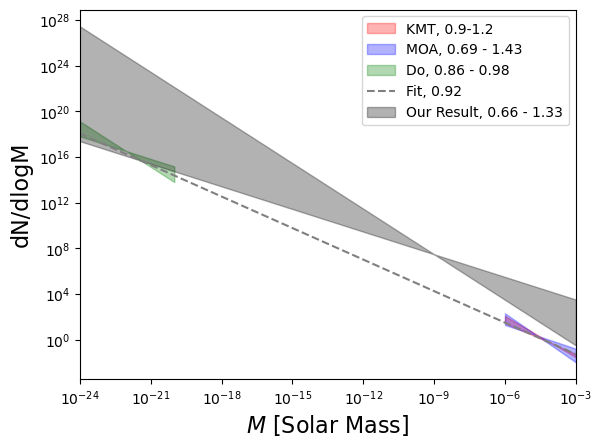

In [213]:
M_arr1 = np.logspace(-6, -3, 100)
M_arr2 = np.logspace(-24, -20, 100)
M_arr3 = np.logspace(-24, -3, 100)

dN_dlogM_arr_MOA = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96-0.27) for M in M_arr1])
dN_dlogM_arr_MOA2 = np.array([dN_dlogM(2.18, M, 3e-6*8, 0.96+0.47) for M in M_arr1])

dN_dlogM_arr_KMT = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.9) for M in M_arr1])
dN_dlogM_arr_KMT2 = np.array([dN_dlogM(0.4, M, 3e-6*38, 1.2) for M in M_arr1])

dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.66) for M in M_arr2])
dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 1.33) for M in M_arr2])

dN_dlogM_arr_fit = np.array([dN_dlogM(0.4, M, 3e-6*38, 0.92) for M in M_arr3])

dN_dlogM_arr_ours = np.array([dN_dlogM(z_133, M, m_norm_133, 1.33) for M in M_arr3])
dN_dlogM_arr_ours2 = np.array([dN_dlogM(z_066, M, m_norm_066, 0.66) for M in M_arr3])


# dN_dlogM_arr_Do = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92-0.06) for M in M_arr2])
# dN_dlogM_arr_Do2 = np.array([dN_dlogM(3.3e16, M, 3e-17 * 3e-6, 0.92+0.06) for M in M_arr2])


plt.fill_between(M_arr1, dN_dlogM_arr_KMT, dN_dlogM_arr_KMT2, alpha=0.3, color='red', label='KMT, 0.9-1.2')
plt.fill_between(M_arr1, dN_dlogM_arr_MOA, dN_dlogM_arr_MOA2, alpha=0.3, color='blue', label='MOA, 0.69 - 1.43')
plt.fill_between(M_arr2, dN_dlogM_arr_Do, dN_dlogM_arr_Do2, alpha=0.3, color='green', label='Do, 0.86 - 0.98')

plt.plot(M_arr3, dN_dlogM_arr_fit, color='gray', label='Fit, 0.92', ls='--')

plt.fill_between(M_arr3, dN_dlogM_arr_ours, dN_dlogM_arr_ours2, alpha=0.3, color='black', label='Our Result, 0.66 - 1.33')
# plt.fill_between(M_arr3, dN_dlogM_arr_ours*0.1, dN_dlogM_arr_ours2*0.1, alpha=0.3, color='black', label='10x Result, 0.66 - 1.33')


# plt.axvline(1e-9, color='black', ls='--')
# plt.axvline(1e-5, color='black', ls='--')


# plt.plot([3e-6, 1e-10], [1.5e4, 2e8], color='black', label='Ours Rough, p=1')
# plt.plot([3e-6, 1e-10], [283847, 75997721], color='black', label='Ours Rough, p=1')
# plt.plot([3e-6, 1e-10], [176, 175771403], color='black', label='Ours Rough, p=1')


plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.xlim(min(M_arr2), max(M_arr1))

plt.xlabel(r"$M$ [Solar Mass]", fontsize=16)
plt.ylabel('dN/dlogM', fontsize=16)

# plt.xlim(1e-7, 1e-1)

plt.show()